### Asset Ops
# Production Forecast - 2023 Only

<a id=Index><a/>
# Table of Contents  <font color='red'></font>
- [Introduction](#Introduction)
- [Project Objective](#Project_Objective)
- [Data Preparation](#Data_preparation)
- [Exploratory Data Analysis](#EDA)
- [Model Development and Evaluation](#Model_development)
  - [Option 1: 10 epochs](#10_epochs)
    1. Basic MLP, SGD
    1. MLP with L2 regularization, Adam
    1. MLP with L2 regularization, Adam, 10% train set allotted to validation set
    1. MLP with L2 regularization, Adam, 10% validation, improved activation functions
  - [Option 2: 300 epochs](#10_epochs)
    1. Basic MLP, SGD
    1. MLP with L2 regularization, Adam
    1. MLP with L2 regularization, Adam, 10% train set allotted to validation set
    1. MLP with L2 regularization, Adam, 10% validation, improved activation functions
  - [Option 3: 10 epochs, 6 neurons](#10_neurons)
    1. Basic MLP, SGD
    1. MLP with L2 regularization, Adam
    1. MLP with L2 regularization, Adam, 10% train set allotted to validation set
    1. MLP with L2 regularization, Adam, 10% validation, improved activation functions
  - [Option 4: 10 epochs, 6 neurons, updating Weight](#weight)
    1. Basic MLP, SGD
    1. MLP with L2 regularization, Adam
    1. MLP with L2 regularization, Adam, 10% train set allotted to validation set
    1. MLP with L2 regularization, Adam, 10% validation, improved activation functions
  - [Option 5: 10 epochs, 6 neurons, updating batch size](#batch)
    1. Basic MLP, SGD
    1. MLP with L2 regularization, Adam
    1. MLP with L2 regularization, Adam, 10% train set allotted to validation set
    1. MLP with L2 regularization, Adam, 10% validation, improved activation functions
  - [Models Analysis](#analysis)
- [Predict](#Predict)
- [Summary](#Summary)

<a id='Data_preparation'></a>
## <font color='blue'>1.- Data Preparation </font>

###### Production and Estimates
1. Exclude 0
2. Exclude NULL

Exclude Estimates < 0  (152 records)




<a id='symbols'></a>
## Import packages

In [1]:
import os
import numpy as np
import csv
from datetime import datetime
import pandas as pd
from numpy import NaN as NA
import numpy.random as random
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ttest_ind
from sklearn.utils import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, roc_curve, precision_score, f1_score
from time import time

%matplotlib inline
sns.set_style('ticks')


In [2]:
np.random.seed(30)
random_state = 30

## Open Source packages for ANN and MLP

In [3]:
import tensorflow as tf
# print(tf.__version__)

In [4]:
from tensorflow import keras
# print(keras.__version__)

In [5]:
# this is so that results are replicable
# DO NOT CHANGE THIS!!
tf.random.set_seed(random_state)

## Read data

In [6]:
#Connect to the server
import pyodbc 
server = 'data-platform-sql-dev-001.database.windows.net'
database = 'data-platform-sqldb-dev-sandbox-impbkups'
username = 'assetopspythn'
password = 'A55tdv$py6'
schema = 'aops'

In [7]:
connectionString = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}'
#print(connectionString)
conn = pyodbc.connect(connectionString) 
query = "SELECT * FROM [aops].[ds_month_prod_3]"
df_prod_t = pd.read_sql_query(query, conn)
df_prod_t.head()
# execution time :15 min  (4:09-4:25)

C:\Users\mjimenez\AppData\Local\Temp\ipykernel_35100\354422073.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_prod_t = pd.read_sql_query(query, conn)


,system_id,prod_date,kWh,Est,Months,Years,pto_DATE_VAR,Age
0,ELP0066995,2021-02-28,433.516,404.628,2,2021,2016-12-16 00:00:00,50
1,ELP0066995,2021-06-30,714.196,727.653,6,2021,2016-12-16 00:00:00,54
2,ELP0066995,2021-04-30,611.937,660.573,4,2021,2016-12-16 00:00:00,52
3,ELP0066995,2021-08-31,555.781,717.557,8,2021,2016-12-16 00:00:00,56
4,ELP0066995,2021-07-31,666.167,729.709,7,2021,2016-12-16 00:00:00,55


In [8]:
prod_t = df_prod_t[df_prod_t['kWh']>30].copy()
prod_t = prod_t[prod_t['kWh']< 10000]
prod_t = prod_t[prod_t['Est'] > 5]

prod_t['Year'] = prod_t['Years'].astype(int)
prod_t['Month_int'] = prod_t['Months'].astype(int)

prod_t = prod_t[prod_t['system_id'] =='ELP0072132']
# 2min

In [9]:
prod_t.shape

(23, 10)

### *verify there is no missing value in both sets*

In [11]:
print('there is {} missing value(s) in the train set'.format(prod_t.isna().sum().sum()))
print('~' * 50)
#print('there is {} missing value(s) in the test set'.format(insur_s.isna().sum().sum()))

there is 0 missing value(s) in the train set
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [57]:
prod_t.dtypes

system_id        object
prod_date        object
kWh             float64
Est             float64
Months           object
Years            object
pto_DATE_VAR     object
Age               int64
Year              int32
Month_int         int32
dtype: object

<a id='EDA'></a>
## <font color='blue'>2.- Exploratory Data Analysis </font>



In [10]:
prod_t.groupby('Year').size()

Year
2021    12
2022     4
2023     7
dtype: int64

In [11]:
prod_t['kWh'].describe().round(3)

count     23.000
mean     465.187
std       99.804
min      257.586
25%      395.742
50%      474.243
75%      546.082
max      583.433
Name: kWh, dtype: float64

In [12]:
prod_t['Est'].describe().round(3)

count     23.000
mean     477.941
std      117.926
min      288.523
25%      371.486
50%      493.061
75%      579.711
max      648.566
Name: Est, dtype: float64

***Analysis***

By removing the outliers (records where kWh <1 and kWh > 200) the data is more consistent.

See the statistics between kWh vs Est

In [17]:
prod_t.info

<bound method DataFrame.info of         system_id   prod_date      kWh       Est Months Years  \
34784  ELP0072132  2023-06-30  543.302  623.9910      6  2023   
34785  ELP0072132  2021-01-31  400.281  351.6082      1  2021   
34786  ELP0072132  2022-02-28  424.629  372.8844      2  2022   
34787  ELP0072132  2021-08-31  546.449  615.2787      8  2021   
34788  ELP0072132  2023-01-31  317.500  346.3537      1  2023   
34789  ELP0072132  2021-06-30  571.058  633.4560      6  2021   
34790  ELP0072132  2021-05-31  583.433  632.8960      5  2021   
34791  ELP0072132  2021-03-31  524.524  496.7874      3  2021   
34792  ELP0072132  2021-07-31  578.747  648.5665      7  2021   
34793  ELP0072132  2023-04-30  561.758  536.0100      4  2023   
34794  ELP0072132  2021-12-31  257.586  325.0691     12  2021   
34795  ELP0072132  2021-09-30  474.243  516.0900      9  2021   
34796  ELP0072132  2023-03-31  447.245  489.3629      3  2023   
34797  ELP0072132  2022-03-31  541.984  493.0612      3  2

In [16]:
prod_t['Month_int'].value_counts(normalize=True)

Month_int
1     0.130435
2     0.130435
3     0.130435
4     0.130435
6     0.086957
5     0.086957
7     0.086957
8     0.043478
12    0.043478
9     0.043478
10    0.043478
11    0.043478
Name: proportion, dtype: float64

***Production by Month***

Years 2021, 2022, 2023

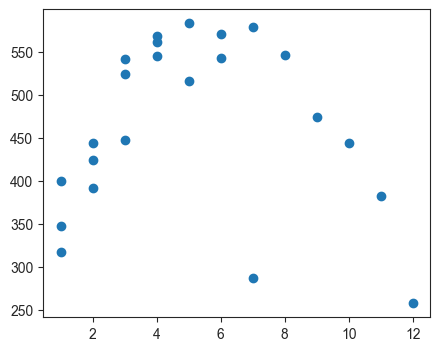

In [13]:
fig, ax=plt.subplots(1,1,figsize=(5,4))
plt.scatter(prod_t.Months.astype(int), prod_t.kWh )


***Analysis***

The data is imbalanced, there are more labels for 0 than for 1

<Axes: >

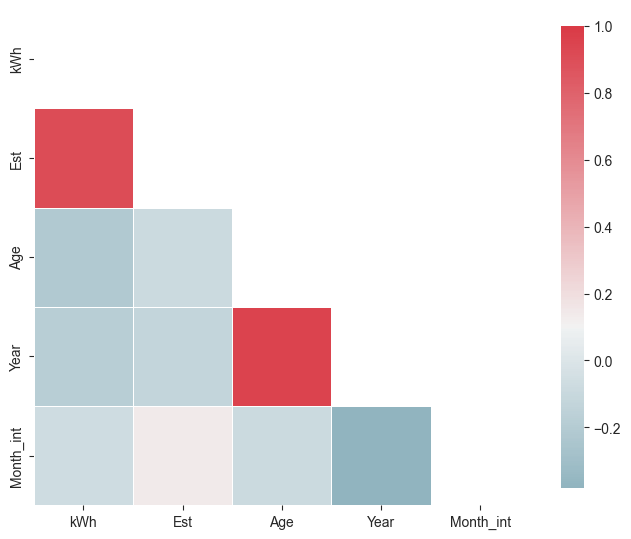

In [14]:
# get the correlation matrix for visualization and for a closer look later
corr = prod_t.drop(labels=[ 'system_id', 'prod_date', 'pto_DATE_VAR', 'Years', 'Months'], axis=1).corr()

# prepare tools for making a half-matrix correlation heatmap
mask = np.triu(np.ones_like(corr, bool))
f, ax = plt.subplots(1,1, figsize=(8, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# plot heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0.1, square=True, ax=ax, 
            linewidths=.5, cbar_kws={'shrink': .75})

In [15]:
corr

,kWh,Est,Age,Year,Month_int
kWh,1.000000,0.909862,-0.219855,-0.182785,-0.070111
Est,0.909862,1.000000,-0.088729,-0.124912,0.141164
Age,-0.219855,-0.088729,1.000000,0.953726,-0.086455
Year,-0.182785,-0.124912,0.953726,1.000000,-0.382005
Month_int,-0.070111,0.141164,-0.086455,-0.382005,1.000000


***Analysis***

There is a Strong correlation between kWh and Est (Actual Production and Estimated Production)

# Preprocess data

##### Dependent Variables : kWh
##### Independent Variables : Est, Year, Months

In [23]:
X = prod_t.drop(columns=['system_id', 'kWh', 'prod_date', 'pto_DATE_VAR', 'Years', 'Months', 'Month_int'])
y = prod_t['kWh'].copy()
print(X.head)
# 2 min

<bound method NDFrame.head of             Est  Age  Year
34784  623.9910   71  2023
34785  351.6082   42  2021
34786  372.8844   55  2022
34787  615.2787   49  2021
34788  346.3537   66  2023
34789  633.4560   47  2021
34790  632.8960   46  2021
34791  496.7874   44  2021
34792  648.5665   48  2021
34793  536.0100   69  2023
34794  325.0691   53  2021
34795  516.0900   50  2021
34796  489.3629   68  2023
34797  493.0612   56  2022
34798  348.9701   54  2022
34799  441.9019   51  2021
34800  378.3930   52  2021
34801  540.0630   57  2022
34802  623.4379   70  2023
34803  288.5232   72  2023
34804  370.0872   67  2023
34805  544.1430   45  2021
34806  375.7012   43  2021>


In [21]:
print(y.head)

<bound method NDFrame.head of 34784    543.302
34785    400.281
34786    424.629
34787    546.449
34788    317.500
34789    571.058
34790    583.433
34791    524.524
34792    578.747
34793    561.758
34794    257.586
34795    474.243
34796    447.245
34797    541.984
34798    347.229
34799    444.195
34800    382.785
34801    568.348
34802    516.136
34803    287.366
34804    391.204
34805    545.716
34806    443.573
Name: kWh, dtype: float64>


#### Split the sample in Train and Test data sets.

In [24]:
# Performing the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)
#1 min

### *Evaluate validity of split using hypothesis-testing*

##### <font color = 'red'> Null hypothesis: The proportion is the same in the train and test sets. <font/>

In [72]:
#not valid analysis
count_default_train = y_train.value_counts()[1]
count_default_test = y_test.value_counts()[1]
z_stat, p = proportions_ztest(count=[count_default_train, count_default_test], nobs=[y_train.shape[0], y_test.shape[0]])
print('z-stat = {:0.3f}, p = {:0.3f}'.format(z_stat, p))

z-stat = -0.323, p = 0.747


**Analysis**:


We assume alpha =0.05.  z_stat=0.369, p=0.712
Becasue p > α which is 0.05, conclude that H0 is not rejected
Conclusion: The proportion of customers who buy insurance is the same in the train and test sets.

### *Column transformer: streamline data preprocessing on train and test sets*

#### ont-hot-encoder

In [24]:
onehot_encoder = OneHotEncoder(drop='first')

# prepare list of column labels for one-hot-encoder
cols_onehot = ['Months']

#### min-max-norm

In [ ]:
## Standardization of data
mmn_scaler = MinMaxScaler()

# prepare list of column labels for mmn-norm: those columns in X_train that are not in cols_onehot
cols_mmn_scale = X_train.drop(columns=cols_onehot).columns.tolist()

In [29]:
## Standardization of data
mmn_scaler = MinMaxScaler()

# prepare list of column labels for mmn-norm: those columns in X_train that are not in cols_onehot
cols_mmn_scale = X_train.columns.tolist()

In [27]:
print(cols_mmn_scale)

['Est', 'Age', 'Year']


### column transformer: X_train and X_test

In [62]:
## NO one_hot_encoder
#transformer = make_column_transformer ((mmn_scaler, cols_mmn_scale))

# use fit_transform() to fit train set X vars
X_train_processed = mmn_scaler.fit_transform(X_train)
#X_train_processed = X_train_processed.toarray()
X_train_processed = pd.DataFrame(X_train_processed)

print(f'query finished successfully {X_train_processed}')
# start time: 9:52

query finished successfully            0         1    2
0   1.000000  0.200000  0.0
1   0.698638  0.500000  0.5
2   0.426001  0.300000  0.0
3   0.632054  0.266667  0.0
4   0.175215  0.000000  0.0
5   0.000000  1.000000  1.0
6   0.578442  0.066667  0.0
7   0.687381  0.900000  1.0
8   0.907545  0.233333  0.0
9   0.167888  0.400000  0.5
10  0.234308  0.433333  0.5
11  0.557821  0.866667  1.0
12  0.226539  0.833333  1.0
13  0.568093  0.466667  0.5
14  0.242132  0.033333  0.0
15  0.958031  0.166667  0.0


In [36]:
transformer = make_column_transformer((onehot_encoder, cols_onehot), (mmn_scaler, cols_mmn_scale))

# use fit_transform() to fit train set X vars
X_train_processed = transformer.fit_transform(X_train)
#X_train_processed = X_train_processed.toarray()
X_train_processed = pd.DataFrame(X_train_processed)

print('query finished successfully')
# start time: 9:52

query finished successfully


In [ ]:
# once fitted to train set, only use transform() on the test set X vars
X_test_processed = transformer.transform(X_test)
X_test_processed = X_test_processed.toarray()
#X_test_processed = pd.DataFrame(X_test_processed)
#10:22 pm

In [35]:
# NO one_hot_enconder
# once fitted to train set, only use transform() on the test set X vars
X_test_processed = mmn_scaler.transform(X_test)
X_test_processed = X_test_processed
#X_test_processed = pd.DataFrame(X_test_processed)
#10:22 pm

### Column Transformer :  Y_test and Y_train

In [83]:
# Since y is a quantitative variable, with Gaussian distribution, we apply Standardization
sc = StandardScaler()


y_train_processed = pd.DataFrame(sc.fit_transform(y_train), columns = ['Prod'])
y_test_processed = pd.DataFrame(sc.transform(y_test), columns = ['Prod'])

ValueError: Expected 2D array, got 1D array instead:
array=[578.747 568.348 444.195 474.243 400.281 287.366 524.524 561.758 546.449
 347.229 424.629 447.245 391.204 541.984 443.573 571.058].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [80]:
print(y_train.head())

34792    578.747
34801    568.348
34799    444.195
34795    474.243
34785    400.281
Name: kWh, dtype: float64


In [61]:
X_train_processed.head()


,0,1,2
0,1.000000,0.200000,0.0
1,0.698638,0.500000,0.5
2,0.426001,0.300000,0.0
3,0.632054,0.266667,0.0
4,0.175215,0.000000,0.0


In [38]:
y_train_processed.head()

,kWh
34792,578.747
34801,568.348
34799,444.195
34795,474.243
34785,400.281


In [39]:
print(pd.DataFrame(X_train_processed).head(5))
#X_train_processed.dtypes
#X_train.head(10)
#X_test_processed.head(10)

          0         1    2
0  1.000000  0.200000  0.0
1  0.698638  0.500000  0.5
2  0.426001  0.300000  0.0
3  0.632054  0.266667  0.0
4  0.175215  0.000000  0.0


In [40]:
display(X_train_processed.shape, y_train_processed.shape,X_test_processed.shape,y_test_processed.shape)

(16, 3)

(16, 1)

(7, 3)

(7, 1)

In [41]:
prod_t['kWh'].head(5)

34784    543.302
34785    400.281
34786    424.629
34787    546.449
34788    317.500
Name: kWh, dtype: float64

<a id='Model_development'></a>
## <font color = 'blue'>3.- Model Development and Evaluation</font>

In [42]:
X_tr = X_train_processed.squeeze()
X_ts = X_test_processed.squeeze()
y_tr = y_train_processed.squeeze()
y_ts = y_test_processed.squeeze()



In [43]:
X_tr.shape, y_tr.shape, X_ts.shape, y_ts.shape

((16, 3), (16,), (7, 3), (7,))

In [44]:
# Review the data
display(pd.DataFrame(X_tr).describe().round(2).loc[['min','max','mean','std']],
        pd.DataFrame(X_ts).describe().round(2).loc[['min','max','mean','std']])

,0,1,2
min,0.00,0.00,0.00
max,1.00,1.00,1.00
mean,0.50,0.42,0.38
std,0.31,0.32,0.43


,0,1,2
min,0.10,0.10,0.00
max,0.96,0.97,1.00
mean,0.58,0.52,0.43
std,0.39,0.37,0.53


## <b> Building the model</b>

**The four model versions:**

1. basic MLP, SGD
1. MLP with L2 regularization, Adam
1. MLP with L2 regularization, Adam, 10% train set allotted to validation set
1. MLP with L2 regularization, Adam, 10% validation, improved activation functions

MLP: Multi=Layer Perceptron

### define a model

In [45]:
model_notes_list = ['basic MLP, SGD', 
                    'MLP L2 regulariz, Adam', 
                    'MLP L2 regulariz, Adam, 10% validation set', 
                    'MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax']

In [70]:
from sklearn.metrics import mean_squared_error

In [76]:
## VALIDATION to identify the best model

scaler = MinMaxScaler()
print('y_ts:')
print(y_ts)
print('X_ts: ')
print(X_ts)

Y_test_escale = scaler.fit_transform(y_ts)
print(Y_test_escaler)

from keras.models import Sequential
from keras.layers import Dense
def FunctionFindBestParams(X_tr, y_tr, X_ts, y_ts):
    
    # Defining the list of hyper parameters to try
    batch_size_list=[5, 10, 15, 20]
    epoch_list  =   [5, 10, 50, 100]
    
    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])
    
    # initializing the trials
    TrialNumber=0
    for batch_size_trial in batch_size_list:
        print('New batch_size')
        for epochs_trial in epoch_list:
            print('New epoch')
            TrialNumber+=1
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units=5, input_dim=X_tr.shape[1], kernel_initializer='normal', activation='relu'))
 
            # Defining the Second layer of the model
            model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
 
            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))
 
            # Compiling the model
            model.compile(loss='mean_squared_error', optimizer='adam')

            print('fitting:')
            # Fitting the ANN to the Training set
            model.fit(X_tr, y_tr ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0)
            

            Y_ts_pred = model.predict(X_ts)
            print('Y_test Predicted')
            print(Y_ts_pred)
            print('inverse:')
            #X_ts_inv = model.inverse_transform(Y_ts_pred)
            #from sklearn.metrics import accuracy_score
            #accuracy = accuracy_score(y_ts, Y_ts_pred)
            #print(accuracy)
            
            # Calculate MSE (Lower better)
            #mse = mean_squared_error(y_ts, Y_ts_pred)
            #print("MSE of testing set:", mse)

            # Calculate MAE
            #mae = mean_absolute_error(y_ts, Y_ts_pred)
            #print("MAE of testing set:", mae)


           # print('diff:')
            diff_x_y_1 = Y_test_escaler - Y_ts_pred #y_ts - Y_ts_pred
            diff_x_y = np.abs(diff_x_y_1)
            div_x_y = diff_x_y / Y_test_escaler #y_ts
           # MAPE = np.mean(100 * (np.abs(y_ts - model.predict(X_ts))/y_ts))
            MAPE = np.mean(100 *  div_x_y)
            # printing the results of the current iteration

            #cost, accuracy, auc, precision,recall ,false_negatives = model.evaluate(X_ts, y_ts)
            
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
            
            SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE]],
                                                                    columns=['TrialNumber', 'Parameters', 'Accuracy'] ))
    return(SearchResultsData)
 
 
######################################################
# Calling the function
ResultsData=FunctionFindBestParams(X_tr, y_tr, X_ts, Y_test_escaler)

#12:28

y_ts:
34794    257.586
34800    382.785
34802    516.136
34784    543.302
34805    545.716
34790    583.433
34788    317.500
Name: kWh, dtype: float64
X_ts: 
          0         1    2
0  0.101504  0.366667  0.0
1  0.249608  0.333333  0.0
2  0.930207  0.933333  1.0
3  0.931743  0.966667  1.0
4  0.709970  0.100000  0.0
5  0.956476  0.133333  0.0
6  0.160621  0.800000  1.0


ValueError: Expected 2D array, got 1D array instead:
array=[257.586 382.785 516.136 543.302 545.716 583.433 317.5  ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Let's begin with a model with 7 hidden layers and 2 outputs. Two layers

In [47]:
# universal variables
m = X_tr.shape[1]; d = 11; t = 1

# computing the cost after each minibatch
minibatch_size = 2**5


# <a id=10_epochs><font color = blue> Option1:10 epochs </font></a>


In [48]:
epochs=50

In [49]:
print(f'step1: start {time()}')
mlp_list=[]
scores_list = []

tf.random.set_seed(random_state)

# track time
start = time()
sgd1 = keras.optimizers.Adam(learning_rate=0.00001)
#1
print(model_notes_list[0])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden'),
                        keras.layers.Dense(t, activation='sigmoid', name='output')])
mlp.compile(optimizer= sgd1, loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall', 'FalsePositives'])

print(f'step2: after optimizer {time()}')

history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0) #  class_weight=classWeight
print(f'step3: score')

scores = history.history

print(f'step4: score')

mlp_list.append(mlp); scores_list.append(scores)

step1: start 1707768697.1477637
basic MLP, SGD
step2: after optimizer 1707768697.8148017

step3: score
step4: score


In [50]:
for model in mlp_list:
    cost, accuracy, auc, precision,recall ,false_positives = model.evaluate(X_ts, y_ts)



1/1 [==============================] - 0s 336ms/step - loss: -145.1643 - accuracy: 0.0000e+00 - auc: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - false_positives: 0.0000e+00


In [55]:
# classWeight = compute_class_weight(class_weight='balanced', classes= np.unique(y_train), y = y_train) 
# classWeight = dict(enumerate(classWeight))

mlp_list=[]
scores_list = []

tf.random.set_seed(random_state)

# track time
start = time()
sgd1 = keras.optimizers.Adam(learning_rate=0.00001)
#1
print(model_notes_list[0])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden'),
                        keras.layers.Dense(t, activation='sigmoid', name='output')])
mlp.compile(optimizer= sgd1, loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall', 'FalsePositives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0) #  class_weight=classWeight
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

#2
# with Regularization and Adam
print('\n' + model_notes_list[1])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden', kernel_regularizer='l2'),
                        keras.layers.Dense(t, activation='sigmoid', name='output', kernel_regularizer='l2')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall','FalsePositives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0) # , class_weight=classWeight
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

#3
# MLP L2 regulariz, Adam, 10% validation set
print('\n' + model_notes_list[2])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden', kernel_regularizer='l2'),
                        keras.layers.Dense(t, activation='sigmoid', name='output', kernel_regularizer='l2')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall', 'FalsePositives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0, validation_split=0.1)
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

#4
# MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax
print('\n' + model_notes_list[3])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='relu', name='hidden', kernel_regularizer='l2'),
                        keras.layers.Dense(t, activation='softmax', name='output', kernel_regularizer='l2')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall', 'FalsePositives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0, validation_split=0.1)
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

# track time
seconds = time() - start
mins, sec = divmod(seconds, 60)   # <-- divmod() returns a tuple of (quotient, remainder) after division
print('\nTook {:.0f} mins and {:.0f} sec'.format(mins, sec))

basic MLP, SGD



MemoryError: Unable to allocate 2.58 GiB for an array with shape (26605672, 13) and data type float64

In [23]:
test_cost_list = []
test_accuracy_list = []
test_auc_list = []
test_fp_list = []
test_f1score_list = []
test_precision_list = []
for model in mlp_list:
    cost, accuracy, auc, precision,recall ,false_positives = model.evaluate(X_ts, y_ts)
    test_cost_list.append(cost)
    test_accuracy_list.append(accuracy)
    test_auc_list.append(auc)
    test_precision_list.append(precision)
    test_fp_list.append(false_positives)
    test_f1score_list.append(2.*(precision*recall)/(precision+recall))

256/256 [==============================] - 1s 2ms/step - loss: 0.4283 - accuracy: 0.8177 - auc: 0.8922 - precision: 0.8177 - recall: 0.8177 - false_positives: 1492.0000


In [24]:
print('-'* 50)
for i in range(4):
    print(f'model: {model_notes_list[i]}')
    print(f'test set cost: {test_cost_list[i]:.4f}')
    print(f'test set accuracy: {test_accuracy_list[i]:.4f}')
    print(f'test set AUC: {test_auc_list[i]:.4f}')
    print(f'test set False Positives: {test_fp_list[i]:.2f}')
    print('-'* 50)

--------------------------------------------------
model: basic MLP, SGD
test set cost: 0.4581
test set accuracy: 0.8177
test set AUC: 0.8798
test set False Positives: 1492.00
--------------------------------------------------
model: MLP L2 regulariz, Adam
test set cost: 0.4750
test set accuracy: 0.8177
test set AUC: 0.8177
test set False Positives: 1492.00
--------------------------------------------------
model: MLP L2 regulariz, Adam, 10% validation set
test set cost: 0.4750
test set accuracy: 0.8177
test set AUC: 0.8177
test set False Positives: 1492.00
--------------------------------------------------
model: MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax
test set cost: 0.4283
test set accuracy: 0.8177
test set AUC: 0.8922
test set False Positives: 1492.00
--------------------------------------------------


In [183]:
test_cost_list = []
test_accuracy_list = []
test_auc_list = []
test_precision_list = []
test_fp_list = []
test_f1score_list = []
for model in mlp_list:
    cost, accuracy, auc, precision,recall ,false_positives = model.evaluate(X_ts, y_ts)
    test_cost_list.append(cost)
    test_accuracy_list.append(accuracy)
    test_auc_list.append(auc)
    test_precision_list.append(precision)
    test_fp_list.append(false_positives)
    test_f1score_list.append(2.*(precision*recall)/(precision+recall))

256/256 [==============================] - 0s 854us/step - loss: 0.4295 - accuracy: 0.8177 - auc: 0.8925 - precision: 0.8177 - recall: 0.8177 - false_positives: 1492.0000


In [184]:
print('-'* 50)
for i in range(4):
    print(f'model: {model_notes_list[i]}')
    print(f'test set cost: {test_cost_list[i]:.4f}')
    print(f'test set accuracy: {test_accuracy_list[i]:.4f}')
    print(f'test set AUC: {test_auc_list[i]:.4f}')
    print(f'test set Precision: {test_precision_list[i]:.4f}')
    print(f'test set False Positives: {test_fp_list[i]:.4f}')
    print('-'* 50)

--------------------------------------------------
model: basic MLP, SGD
test set cost: 0.5656
test set accuracy: 0.8177
test set AUC: 0.8591
test set Precision: 0.8157
test set False Positives: 1492.0000
--------------------------------------------------
model: MLP L2 regulariz, Adam
test set cost: 0.4783
test set accuracy: 0.8177
test set AUC: 0.8857
test set Precision: 0.8157
test set False Positives: 1492.0000
--------------------------------------------------
model: MLP L2 regulariz, Adam, 10% validation set
test set cost: 0.4798
test set accuracy: 0.8177
test set AUC: 0.8817
test set Precision: 0.8157
test set False Positives: 1492.0000
--------------------------------------------------
model: MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax
test set cost: 0.4295
test set accuracy: 0.8177
test set AUC: 0.8925
test set Precision: 0.8157
test set False Positives: 1492.0000
--------------------------------------------------


# <a id=weight><font color = blue> Option 4: 10 epochs, 6 neurons, updating weight </font></a>


In [210]:
# universal variables
d =6
epochs = 10

In [203]:
classWeight = compute_class_weight(class_weight='balanced', classes= np.unique(y_train), y = y_train) 
classWeight = dict(enumerate(classWeight))

mlp_list=[]
scores_list = []

tf.random.set_seed(random_state)

# track time
start = time()
sgd1 = keras.optimizers.Adam(learning_rate=0.00001)
#1
print(model_notes_list[0])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden'),
                        keras.layers.Dense(t, activation='sigmoid', name='output')])
mlp.compile(optimizer= sgd1, loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall', 'FalsePositives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0,  class_weight=classWeight)
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

#2
# with Regularization and Adam
print('\n' + model_notes_list[1])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden', kernel_regularizer='l2'),
                        keras.layers.Dense(t, activation='sigmoid', name='output', kernel_regularizer='l2')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall','FalsePositives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0,  class_weight=classWeight)
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

#3
# MLP L2 regulariz, Adam, 10% validation set
print('\n' + model_notes_list[2])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden', kernel_regularizer='l2'),
                        keras.layers.Dense(t, activation='sigmoid', name='output', kernel_regularizer='l2')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall', 'FalsePositives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0, validation_split=0.1,  class_weight=classWeight)
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

#4
# MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax
print('\n' + model_notes_list[3])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='relu', name='hidden', kernel_regularizer='l2'),
                        keras.layers.Dense(t, activation='softmax', name='output', kernel_regularizer='l2')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall', 'FalsePositives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0, validation_split=0.1,  class_weight=classWeight)
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

# track time
seconds = time() - start
mins, sec = divmod(seconds, 60)   # <-- divmod() returns a tuple of (quotient, remainder) after division
print('\nTook {:.0f} mins and {:.0f} sec'.format(mins, sec))

basic MLP, SGD

MLP L2 regulariz, Adam

MLP L2 regulariz, Adam, 10% validation set

MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax

Took 0 mins and 14 sec


In [204]:
test_cost_list = []
test_accuracy_list = []
test_auc_list = []
test_precision_list = []
test_fp_list = []
test_f1score_list = []
for model in mlp_list:
    cost, accuracy, auc, precision,recall ,false_positives = model.evaluate(X_ts, y_ts)
    test_cost_list.append(cost)
    test_accuracy_list.append(accuracy)
    test_auc_list.append(auc)
    test_precision_list.append(precision)
    test_fp_list.append(false_positives)
    test_f1score_list.append(2.*(precision*recall)/(precision+recall))

256/256 [==============================] - 0s 904us/step - loss: 0.6183 - accuracy: 0.5609 - auc: 0.6999 - precision: 0.5609 - recall: 0.5609 - false_positives: 3594.0000


In [205]:
print('-'* 50)
for i in range(4):
    print(f'model: {model_notes_list[i]}')
    print(f'test set cost: {test_cost_list[i]:.4f}')
    print(f'test set accuracy: {test_accuracy_list[i]:.4f}')
    print(f'test set AUC: {test_auc_list[i]:.4f}')
    print(f'test set Precision: {test_precision_list[i]:.4f}')
    print(f'test set False Positives: {test_fp_list[i]:.4f}')
    print('-'* 50)

--------------------------------------------------
model: basic MLP, SGD
test set cost: 0.6306
test set accuracy: 0.8173
test set AUC: 0.8493
test set Precision: 0.8157
test set False Positives: 1945.0000
--------------------------------------------------
model: MLP L2 regulariz, Adam
test set cost: 0.6925
test set accuracy: 0.5547
test set AUC: 0.6749
test set Precision: 0.8157
test set False Positives: 3669.0000
--------------------------------------------------
model: MLP L2 regulariz, Adam, 10% validation set
test set cost: 0.6817
test set accuracy: 0.5584
test set AUC: 0.7244
test set Precision: 0.8157
test set False Positives: 3614.0000
--------------------------------------------------
model: MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax
test set cost: 0.6183
test set accuracy: 0.5609
test set AUC: 0.6999
test set Precision: 0.8157
test set False Positives: 3594.0000
--------------------------------------------------


[Go to Index](#Index)

# <a id=batch><font color = blue> Option 5: 10 epochs, 6 neurons, increase the batches </font></a>


In [25]:
# universal variables
d =6
epochs = 20
minibatch_size = 2**12

In [26]:
# classWeight = compute_class_weight(class_weight='balanced', classes= np.unique(y_train), y = y_train) 
# classWeight = dict(enumerate(classWeight))

mlp_list=[]
scores_list = []

tf.random.set_seed(random_state)

# track time
start = time()
sgd1 = keras.optimizers.Adam(learning_rate=0.00001)
#1
print(model_notes_list[0])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden'),
                        keras.layers.Dense(t, activation='sigmoid', name='output')])
mlp.compile(optimizer= sgd1, loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall', 'FalseNegatives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0) #  class_weight=classWeight
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

#2
# with Regularization and Adam
print('\n' + model_notes_list[1])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden', kernel_regularizer='l2'),
                        keras.layers.Dense(t, activation='sigmoid', name='output', kernel_regularizer='l2')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall','FalseNegatives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0) # , class_weight=classWeight
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

#3
# MLP L2 regulariz, Adam, 10% validation set
print('\n' + model_notes_list[2])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden', kernel_regularizer='l2'),
                        keras.layers.Dense(t, activation='sigmoid', name='output', kernel_regularizer='l2')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall', 'FalseNegatives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0, validation_split=0.1)
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

#4
# MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax
print('\n' + model_notes_list[3])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='relu', name='hidden', kernel_regularizer='l2'),
                        keras.layers.Dense(t, activation='softmax', name='output', kernel_regularizer='l2')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall', 'FalseNegatives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0, validation_split=0.1)
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

# track time
seconds = time() - start
mins, sec = divmod(seconds, 60)   # <-- divmod() returns a tuple of (quotient, remainder) after division
print('\nTook {:.0f} mins and {:.0f} sec'.format(mins, sec))

basic MLP, SGD

MLP L2 regulariz, Adam

MLP L2 regulariz, Adam, 10% validation set

MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax

Took 0 mins and 20 sec


In [27]:
test_cost_list = []
test_accuracy_list = []
test_auc_list = []
test_precision_list = []
test_fp_list = []
test_f1score_list = []
for model in mlp_list:
    cost, accuracy, auc, precision,recall ,false_negatives = model.evaluate(X_ts, y_ts)
    test_cost_list.append(cost)
    test_accuracy_list.append(accuracy)
    test_auc_list.append(auc)
    test_precision_list.append(precision)
    test_fp_list.append(false_negatives)
    test_f1score_list.append(2.*(precision*recall)/(precision+recall))

256/256 [==============================] - 0s 2ms/step - loss: 0.6439 - accuracy: 0.8177 - auc: 0.7736 - precision: 0.8177 - recall: 0.8177 - false_negatives: 1492.0000


In [28]:
print('-'* 50)
for i in range(4):
    print(f'model: {model_notes_list[i]}')
    print(f'test set cost: {test_cost_list[i]:.4f}')
    print(f'test set accuracy: {test_accuracy_list[i]:.4f}')
    print(f'test set AUC: {test_auc_list[i]:.4f}')
    print(f'test set Precision: {test_precision_list[i]:.4f}')
    print(f'test set False Negatives: {test_fp_list[i]:.2f}')
    print(f'test set F1-score: {test_f1score_list[i]:.4f}')
    print('-'* 50)

--------------------------------------------------
model: basic MLP, SGD
test set cost: 0.6149
test set accuracy: 0.8177
test set AUC: 0.8527
test set Precision: 0.7819
test set False Negatives: 1292.00
test set F1-score: 0.8109
--------------------------------------------------
model: MLP L2 regulariz, Adam
test set cost: 0.6950
test set accuracy: 0.8177
test set AUC: 0.8252
test set Precision: 0.8187
test set False Negatives: 1680.00
test set F1-score: 0.8065
--------------------------------------------------
model: MLP L2 regulariz, Adam, 10% validation set
test set cost: 0.9848
test set accuracy: 0.1823
test set AUC: 0.1686
test set Precision: 0.1797
test set False Negatives: 6753.00
test set F1-score: 0.1773
--------------------------------------------------
model: MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax
test set cost: 0.6439
test set accuracy: 0.8177
test set AUC: 0.7736
test set Precision: 0.8177
test set False Negatives: 1492.00
test set F1-score: 0.8177
----

[Go to Index](#Index)

### plot cost curve of 4 models

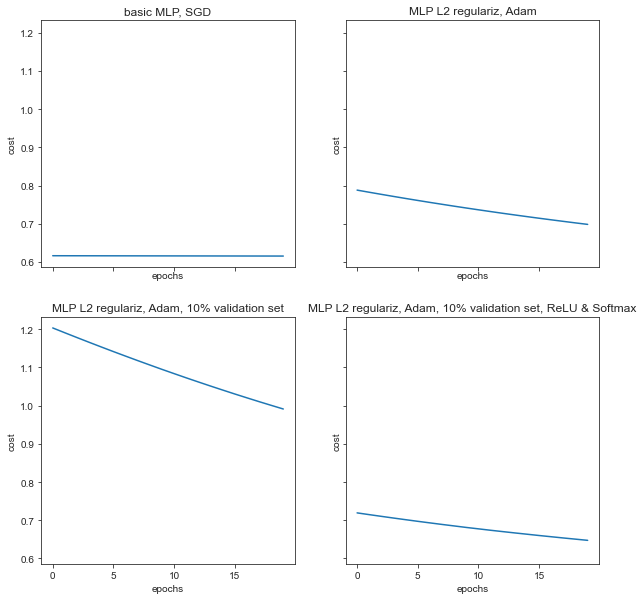

In [29]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        axx = ax[i, j]
        axx.plot(scores_list[i+j+(i==1)]['loss'])
        axx.set_title(model_notes_list[i+j+(i==1)])
        axx.set_xlabel('epochs')
        axx.set_ylabel('cost')

### plot test set accuracy of 4 models

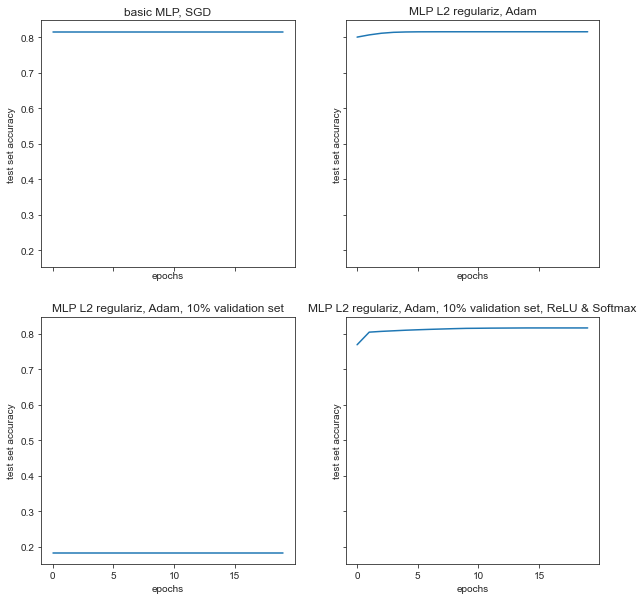

In [30]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        axx = ax[i, j]
        axx.plot(scores_list[i+j+(i==1)]['accuracy'])
        axx.set_title(model_notes_list[i+j+(i==1)])
        axx.set_xlabel('epochs')
        axx.set_ylabel('test set accuracy')

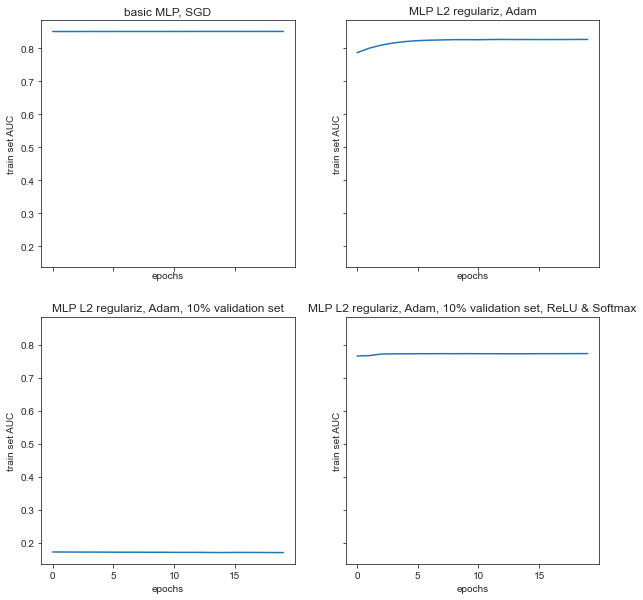

In [31]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        axx = ax[i, j]
        axx.plot(scores_list[i+j+(i==1)]['auc'])
        axx.set_title(model_notes_list[i+j+(i==1)])
        axx.set_xlabel('epochs')
        axx.set_ylabel('train set AUC')

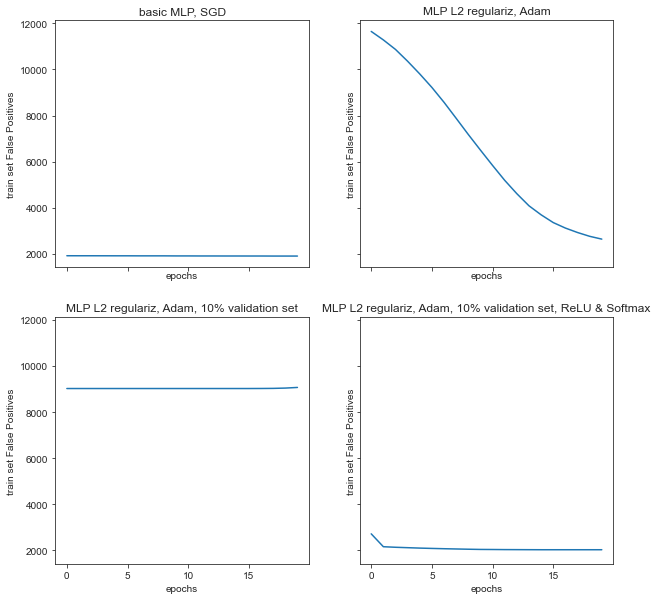

In [32]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        axx = ax[i, j]
        axx.plot(scores_list[i+j+(i==1)]['false_negatives'])
        axx.set_title(model_notes_list[i+j+(i==1)])
        axx.set_xlabel('epochs')
        axx.set_ylabel('train set False Positives')

[Go to Index](#Index)

### Finally, examine test and train set accuracy after sufficient training of all 4 models

In [33]:
test_cost_list = []
test_accuracy_list = []
test_auc_list = []
test_precision_list = []
test_fp_list = []
test_f1score_list = []
for model in mlp_list:
    cost, accuracy, auc, precision,recall ,false_negatives = model.evaluate(X_tr, y_tr)
    test_cost_list.append(cost)
    test_accuracy_list.append(accuracy)
    test_auc_list.append(auc)
    test_precision_list.append(precision)
    test_fp_list.append(false_negatives)
    test_f1score_list.append(2.*(precision*recall)/(precision+recall))
    

384/384 [==============================] - 1s 2ms/step - loss: 0.6459 - accuracy: 0.8157 - auc: 0.7717 - precision: 0.8157 - recall: 0.8157 - false_negatives: 2263.0000


In [354]:
test_cost_list = []
test_accuracy_list = []
test_auc_list = []
test_fp_list = []
test_f1score_list = []
for model in mlp_list:
    cost, accuracy, auc, precision,recall ,false_negatives = model.evaluate(X_ts, y_ts)
    test_cost_list.append(cost)
    test_accuracy_list.append(accuracy)
    test_auc_list.append(auc)
    test_precision_list.append(precision)
    test_fp_list.append(false_negatives)
    test_f1score_list.append(2.*(precision*recall)/(precision+recall))

256/256 [==============================] - 0s 927us/step - loss: 0.6439 - accuracy: 0.8177 - auc: 0.7736 - precision: 0.8177 - recall: 0.8177 - false_negatives: 1492.0000


In [34]:
print('-'* 50)
for i in range(4):
    print(f'model: {model_notes_list[i]}')
    print(f'test set cost: {test_cost_list[i]:.4f}')
    print(f'test set accuracy: {test_accuracy_list[i]:.4f}')
    print(f'test set AUC: {test_auc_list[i]:.4f}')
    print('-'* 50)

--------------------------------------------------
model: basic MLP, SGD
test set cost: 0.6154
test set accuracy: 0.8157
test set AUC: 0.8503
--------------------------------------------------
model: MLP L2 regulariz, Adam
test set cost: 0.6957
test set accuracy: 0.8157
test set AUC: 0.8259
--------------------------------------------------
model: MLP L2 regulariz, Adam, 10% validation set
test set cost: 0.9838
test set accuracy: 0.1843
test set AUC: 0.1704
--------------------------------------------------
model: MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax
test set cost: 0.6459
test set accuracy: 0.8157
test set AUC: 0.7717
--------------------------------------------------


[Go to Index](#Index)

<a id = analysis></a>
## Analysis:

1. We test our model with epoch = 10 and epochs = 300. The performance of the model with 10 epochs was slightly better: <br>

1. Increasing Neurons in hidden layers, with 10 epochs 

<u>hidden neurons = 10</u></p>
model: MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax<br>
test set cost: 0.4281<br>
test set accuracy: 0.8177<br>
test set AUC: 0.8923<br>
test set False Positives: 1492.0000<br>

<u>hidden neurons = 6, 10 epochs</u><br>
model: MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax<br>
test set cost: **0.4295**<br>
test set accuracy: 0.8177<br>
test set AUC: **0.8925**<br>
test set Precision: 0.8157<br>
test set False Positives: 1492.0000<br>

<u>hidden neurons = 7, 10 epochs</u><br>
model: MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax<br>
test set cost: **0.4301**<br>
test set accuracy: 0.8177<br>
test set AUC: **0.8925**<br>
test set Precision: 0.8157<br>
test set False Positives: 1492.0000<br>

<u>hidden neurons = 5, 10 epochs:</u><br>
model: MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax<br>
test set cost: 0.4295<br>
test set accuracy: 0.8177<br>
test set AUC: 0.8922<br>
test set False Positives: 1492.0000

1. Since the dataset is **imbalanced**, we modify the batch  size:
<u>MLP L2 regulariz, Adam, batch size: 2\*\*12</u><br>
test set cost: 0.7376<br>
test set accuracy: 0.8177<br>
test set AUC: 0.8246<br>
test set Precision: 0.8157<br>
test set False Positives: 984.00<br><br>
test set F1-score: 0.6257<br>

<u> MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax, batch size: 2\*\*12</u><br>
test set cost: 0.6776<br>
test set accuracy: 0.8172<br>
test set AUC: 0.7723<br>
test set Precision: 0.8157<br>
test set False Positives: 1496.00<br>
test set F1-score: **0.8172**<br>

<u>basic MLP, SGD, batch size: 2\*\*16</u><br>
test set cost: 0.6157<br>
test set accuracy: 0.8177<br>
test set AUC: 0.8524<br>
test set Precision: 0.8157<br>
test set False Positives: 1931.00<br>
test set F1-score: 0.8106<br>

<u>MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax, batch size: 2\*\*10</u><br>
test set cost: 0.6019<br>
test set accuracy: **0.8177** <br>
test set AUC: 0.7830<br>
test set Precision: 0.8157<br>
test set False Positives: 1492.00<br>
test set F1-score: **0.8177**<br>

<u>model: MLP L2 regulariz, Adam , batch size: 2\*\*10</u><br>
test set cost: 0.6326<br>
test set accuracy: **0.8177**<br>
test set AUC: 0.8255
test set Precision: 0.8157<br>
test set False Positives: 1492.00<br>
test set F1-score: **0.8177**<br>

<u>model: basic MLP, SGD , batch size: 2\*\*12</u><br>
test set cost: 0.6154<br>
test set accuracy: 0.8177<br>
test set AUC: **0.8526**
test set Precision: 0.8157<br>
test set False Positives: 1928.00<br>
test set F1-score: 0.8107<br>


<u>model: basic MLP, SGD, batch size: 2\*\*12, epochs: 20</u><br>
test set cost: 0.6149<br>
test set accuracy: 0.8177<br>
test set AUC: <font color = 'blue'>**0.8527**</font><br>
test set Precision: 0.7856<br>
test set False Positives: 1922.00<br><br>
test set F1-score: 0.8109<br>

<u>model: MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax, batch size: 2\*\*12, epochs: 200</u><br>
test set cost: 0.4430
test set accuracy: 0.8177
test set AUC: 0.8924
test set Precision: 0.8157
test set False Positives: 1492.00
test set F1-score: 0.8177

model: MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax
test set cost: 0.4283
test set accuracy: 0.8177
test set AUC: 0.8922
test set False Positives: 1492.00

model: MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax
test set cost: 0.4903
test set accuracy: 0.8177
test set AUC: 0.8788
test set Precision: 0.8157
test set False Positives: 1492.00
test set F1-score: 0.8177


[Go to Index](#Index)

<a id='Predict'></a>
## <font color = 'blue'>4.- Predict</font>

## <b> The final model</b>

In [35]:
epochs=20
d=6
minibatch_size=2**12
sgd1 = keras.optimizers.Adam(learning_rate=0.00001)
#1
print(model_notes_list[0])
f_mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden'),
                        keras.layers.Dense(t, activation='sigmoid', name='output')])
f_mlp.compile(optimizer= sgd1, loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall', 'FalsePositives'])
f_mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0) #  class_weight=classWeight
#scores = history.history
#mlp_list.append(mlp); scores_list.append(scores)

basic MLP, SGD


[Go to Index](#Index)

## Prepare the Score data

### Compairing columns

In [270]:
print('Is there any difference in the input column labels between the two dataframes?', 
      (insur_s.columns != insur_t.drop('buy', axis=1).columns).any())

Is there any difference in the input column labels between the two dataframes? False


In [36]:
df_score = insur_s.drop(columns=['id_new'])

In [37]:
print(f'These columns have at least 1 missing value: {df_score.columns[df_score.isnull().sum().astype(bool)].tolist()}')

These columns have at least 1 missing value: []


#### column transformer

In [38]:
# transformer = make_column_transformer((onehot_encoder, cols_onehot), (mmn_scaler, cols_mmn_scale))

X_score = transformer.transform(df_score)
X_score= pd.DataFrame(X_score)


In [39]:
X_s = X_score.squeeze().to_numpy()
X_s.shape

(2000, 13)

In [45]:
y=f_mlp.predict_classes(X_score, batch_size=2**10)
y_probability = f_mlp.predict(X_score)

In [60]:
# show the inputs and predicted outputs
for i in range(len(X_s)):
	print("X=%s, Predicted=%s, Probability=%s" % (X_s[i], y[i], y_probability[i,1]))

X=[1.         0.         0.         1.         0.         0.
 1.         1.         0.         0.4        0.39446367 0.11538462
 0.05026714], Predicted=0, Probability=0.50762796
X=[0.         1.         0.         1.         0.         1.
 0.         1.         0.         0.07692308 0.95155709 0.88461538
 0.08933304], Predicted=1, Probability=0.60280746
X=[1.         0.         0.         0.         0.         0.
 0.         1.         1.         0.33846154 0.29411765 0.53846154
 0.06000273], Predicted=0, Probability=0.5635471
X=[0.         0.         0.         1.         0.         0.
 1.         1.         0.         0.29230769 0.75778547 0.5
 0.0703838 ], Predicted=1, Probability=0.55723774
X=[1.         0.         0.         1.         0.         0.
 0.         1.         0.         0.33846154 0.35986159 0.53846154
 0.06265072], Predicted=1, Probability=0.54757977
X=[0.         0.         0.         1.         0.         0.
 0.         1.         0.         0.43076923 0.06574394 0

In [76]:
predictedS = pd.DataFrame(list(zip(insur_s['id_new'], y_probability[:,1], y)), 
                          columns=['id_new','Probability', 'Classification'])

In [77]:
predictedS.to_csv("Scored_Buy_final.csv", index=False)

[Index](#Index)

<a id='Summary'></a>
## <font color = 'blue'>4.- Summary</font>

1. The `Accuracy`remains the same for all models, that's why we decided to analyze the AUC, cost and F1-score.

1. For this case we consider that a `False Negative` is worst than a False Positive. A False Negative is when the model predict that the customer will not buy the insurance so the sales representative does not call him, but in fact, the client will buy the insurance.<br>
If the model incorrectly classify a client as a not buyer and he is a buyer, the company will lose the opportunity to sell the insurance.

1. We noticed that the data is imbalanced, then we modified the batch size so the training model can take some values with 0 and 1. We suspect that in our previous models most of the samples have 0 values for all rows, that's why it predicted 0s for all cases. With a wider batch size, our model is now including samples with labels = 1 and it is learning properly.

1. Finally, we choose model: <u>model: basic MLP, SGD, batch size: 2\*\*12, epochs: 20</u><br>
test set cost: 0.6149<br>
test set accuracy: 0.8177<br>
test set AUC: <font color = 'blue'>**0.8527**</font><br>
test set Precision: 0.7856<br>
test set False Positives: 1922.00<br>
test set F1-score: 0.8109<br>